In [1]:
import numpy as np, numpy.random as npr, torch.nn as nn, copy, timeit, torch, seaborn as sns
from torch.distributions.bernoulli import Bernoulli 
from tqdm import trange
from HMCfunctions_old import *
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import plot, show, legend

Gradient w.r.t. $\theta$:

$$
\nabla_\theta \log p(\theta \mid \sigma, x_{1:n}, y_{1:n}) 
= 
- \sum_{i=1}^n \frac{\left ( \mu_\theta(x_i) - y_i \right ) \, \nabla_\theta \mu_\theta(x_i) }{\sigma^{2k}} + \nabla_\theta \log p_0(\theta) 
$$

#### Set up neural network:

In [2]:
n_in = 1
n_h1 = 5
n_out = 2

nn_model = nn.Sequential(nn.Linear(n_in, n_h1),
                         nn.Tanh(),
                         nn.Linear(n_h1, n_out))

* Total number of parameters:

In [3]:
print(sum(p.numel() for p in nn_model.parameters()))

22


#### Generate some random data:

In [4]:
error_sigma = 2e-1
nobs = 1_000
xtrue = torch.randn(nobs, n_in, requires_grad=True)
xvals = xtrue.data
ytrue = np.zeros((nobs, n_out))
ytrue[:,0] = list(abs(xvals)*np.cos(xvals))
ytrue[:,1] = list(abs(xvals)*np.sin(xvals))
ytrue = 3*torch.from_numpy(ytrue).float() + torch.randn(nobs,2)*error_sigma
criterion = nn.MSELoss()

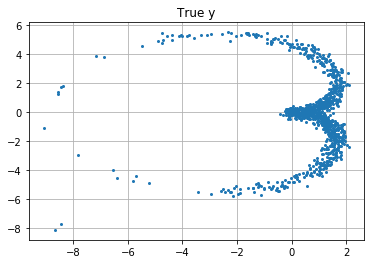

In [5]:
plt.plot(list(ytrue[:,0]), list(ytrue[:,1]), 'o', markersize=2)
plt.grid(True)
plt.title("True y");

### HMC: 

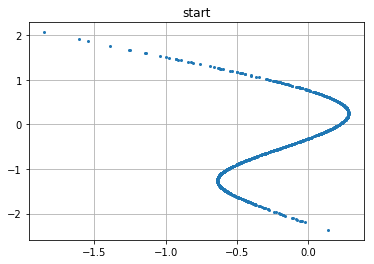

In [17]:
prior_sigma = 1e0
my_model = model(xtrue, ytrue, prior_sigma, 1e0, nn_model)
my_model.init_normal()
my_model.update_grad()
y_initial = my_model.nn_model(my_model.x)
plt.plot(list(y_initial[:,0]), list(y_initial[:,1]), 'o', markersize=2)
plt.grid(True)
plt.title("start");

In [18]:
torch.min(my_model.get_params()), torch.max(my_model.get_params())

(tensor(-3.1110), tensor(3.4275))

* Define thermostat:

In [19]:
stepsize = 1e-3
my_thermostat = thermostat(my_model, stepsize)

* Define HMC sampler:

In [20]:
Nsteps = 1000
n_leapfrog = 100
hmc = HMC(my_thermostat, Nsteps, n_leapfrog)

* Run HMC sampler:

In [ ]:
hmc.run()
hmc.plot()

iter    100/1000 after 0.20 min | accept_rate 1.000 | MSE loss 4.254


In [12]:
min(hmc.ESS()), max(hmc.ESS())

(2.821805849698102, 42.470199382906124)

### BAOAB:

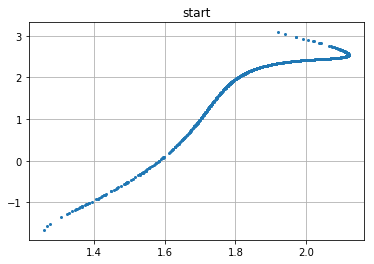

In [13]:
my_model.init_normal()
my_model.update_grad()
y_initial = my_model.nn_model(my_model.x)
plt.plot(list(y_initial[:,0]), list(y_initial[:,1]), 'o', markersize=2)
plt.grid(True)
plt.title("start");

* Define thermostat:

In [14]:
stepsize = 1e-2
my_thermostat = thermostat(my_model, stepsize)

* Define BAOAB sampler:

In [15]:
beta = 1
gamma = 1e0
baoab = BAOAB(my_thermostat, 10**4, beta, gamma)

* Run sampler:

iter   1000/10000 after 0.08 min | accept_rate 0.151 | MSE loss 4.466
iter   2000/10000 after 0.16 min | accept_rate 0.085 | MSE loss 4.455
iter   3000/10000 after 0.23 min | accept_rate 0.059 | MSE loss 4.452
iter   4000/10000 after 0.31 min | accept_rate 0.044 | MSE loss 4.438
iter   5000/10000 after 0.39 min | accept_rate 0.036 | MSE loss 4.442
iter   6000/10000 after 0.47 min | accept_rate 0.031 | MSE loss 4.445
iter   7000/10000 after 0.56 min | accept_rate 0.027 | MSE loss 4.444
iter   8000/10000 after 0.63 min | accept_rate 0.024 | MSE loss 4.446
iter   9000/10000 after 0.71 min | accept_rate 0.021 | MSE loss 4.444
iter  10000/10000 after 0.80 min | accept_rate 0.019 | MSE loss 4.437


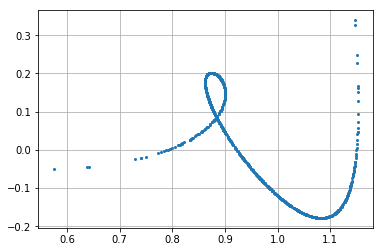

In [16]:
baoab.run()
baoab.plot()

In [19]:
baoab.ESS()

array([5318.66460867, 1583.60213647, 4058.74236837, ...,  462.00512337,
        248.77526599, 2606.13577039])